# WiDS Datathon 2021

Target : Area under the Receiver Operating Characteristic (ROC) curve between the predicted and the observed target (diabetes_mellitus_diagnosis).

by : Sebastián Uribe Ocampo

## Libraries

In [166]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
sns.set_style("whitegrid")
#import plotly.express as px
# pd.options.plotting.backend = "plotly"
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 100)

In [217]:
from scipy.stats import chi2_contingency

# LOAD DATA

In [133]:
diabetes = pd.read_csv("../../data/raw/TrainingWiDS2021.csv")

In [134]:
diabetes.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,...,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0,14.1,46.0,32.0,68.0,37.0,68.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,1,12.7,NaN,NaN,95.0,31.0,95.0,...,9.0,9.0,8.6,8.6,0.56,0.56,145.0,143.0,27.0,27.0,11.3,11.3,36.9,36.9,1.3,1.3,3.5,3.5,557.0,557.0,4.2,4.2,145.0,145.0,12.7,12.7,37.0,37.0,7.45,7.45,51.0,51.0,54.8,51.000000,37.0,37.0,7.45,7.45,51.0,51.0,51.0,51.0,0,0,0,0,0,0,0,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,93,admit,Med-Surg ICU,0.000694,0,95.3,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,5.0,NaN,102.0,NaN,0,68.0,NaN,NaN,NaN,NaN,37.0,NaN,36.7,NaN,0,NaN,NaN,NaN,88.0,48.0,88.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,92,admit,CTICU,0.000694,0,61.7,NaN,203.0,1206.03,1,0,NaN,NaN,NaN,0.6,4.0,6.0,0.0,5.0,185.0,114.0,25.9,1,60.0,30.0,30.0,142.0,7.39,4.0,NaN,34.8,NaN,1,8.0,62.0,30.0,48.0,42.0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.6,11.6,34.0,34.0,1.6,1.1,NaN,NaN,43.0,43.0,NaN,NaN,NaN,NaN,8.8,8.8,37.0,27.0,7.44,7.34,337.0,102.0,342.5,236.666667,36.0,33.0,7.37,7.34,337.0,265.0,337.0,337.0,0,0,0,0,0,0,0,0
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,91,admit,Med-Surg ICU,0.073611,0,NaN,NaN,119.0,601.01,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,0,103.0,NaN,NaN,NaN,NaN,16.0,NaN,36.7,NaN,0,NaN,NaN,NaN,99.0,57.0,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


In [135]:
print("Train File Size   : ",diabetes.shape)
print("# encounter_id    : ",diabetes.encounter_id.nunique())
print("# hospital_id     : ",diabetes.hospital_id.nunique())

Train File Size   :  (130157, 181)
# encounter_id    :  130157
# hospital_id     :  204


In [138]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130157 entries, 0 to 130156
Columns: 181 entries, Unnamed: 0 to diabetes_mellitus
dtypes: float64(157), int64(18), object(6)
memory usage: 179.7+ MB


# EDA

In [136]:
data_info = pd.read_csv("../../docs/DataDictionaryWiDS2021.csv")
data_info["Category"].value_counts()

labs                  60
vitals                52
APACHE covariate      28
labs blood gas        16
demographic           15
APACHE comorbidity     7
identifier             2
Target Variable        1
Name: Category, dtype: int64

According to DataDictionaryWiDS2021.csv file there are 6 different kind of sources of information. .. Lets analyze each of them 

In [137]:
data_info.groupby(["Category"])["Data Type"].value_counts()

Category            Data Type
APACHE comorbidity  binary        7
APACHE covariate    numeric      18
                    binary        5
                    integer       3
                    string        2
Target Variable     binary        1
demographic         string        8
                    numeric       4
                    binary        2
                    integer       1
identifier          integer       2
labs                numeric      60
labs blood gas      numeric      16
vitals              numeric      52
Name: Data Type, dtype: int64

## identifier hospital_id

In [88]:
diabetes["hospital_id"].value_counts()

118    4306
19     3885
188    3075
86     2962
7      2944
       ... 
23        7
95        6
93        6
130       2
25        2
Name: hospital_id, Length: 204, dtype: int64

In [89]:
diabetes["hospital_id"].value_counts(1).head()

118    0.033083
19     0.029849
188    0.023625
86     0.022757
7      0.022619
Name: hospital_id, dtype: float64

In [115]:
diabetes.groupby(["hospital_id"]).agg(n_encounter   =("encounter_id","count"),
                                      total_diabetes =("diabetes_mellitus","sum"),
                                      diabetes_rate =("diabetes_mellitus","mean")
                                      ).query('diabetes_rate > 0.3 & n_encounter >50')\
                                       .sort_values(["diabetes_rate"],ascending=False)5

,n_encounter,total_diabetes,diabetes_rate
hospital_id,,,
51,110,41,0.372727
37,734,266,0.362398
128,1029,352,0.342080
8,388,128,0.329897
200,367,119,0.324251
58,1344,435,0.323661
16,267,84,0.314607
94,176,55,0.312500
88,61,19,0.311475


## demographic

In [239]:
data_info[data_info["Category"]=="demographic"].sort_values(["Data Type","Variable Name"])

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
4,demographic,elective_surgery,None,binary,Whether the patient was admitted to the hospit...,0
15,demographic,readmission_status,None,binary,Whether the current unit stay is the second (o...,0
11,demographic,icu_id,None,integer,A unique identifier for the unit to which the ...,None
2,demographic,age,Years,numeric,The age of the patient on unit admission,None
7,demographic,height,centimetres,numeric,The height of the person on unit admission,180
14,demographic,pre_icu_los_days,Days,numeric,The length of stay of the patient between hosp...,3.5
16,demographic,weight,kilograms,numeric,The weight (body mass) of the person on unit a...,80
3,demographic,bmi,kilograms/metres^2,string,The body mass index of the person on unit admi...,21.5
5,demographic,ethnicity,None,string,The common national or cultural tradition whic...,Caucasian
6,demographic,gender,None,string,The genotypical sex of the patient,F


In [245]:
data_info[data_info["Variable Name"]=="icu_id"]["Description"][11]

'A unique identifier for the unit to which the patient was admitted'

In [248]:
demographic_features = ["encounter_id","hospital_id"]
demographic_features = demographic_features + data_info[data_info["Category"]=="demographic"].sort_values(["Data Type","Variable Name"])["Variable Name"].unique().tolist()
demographic_features.remove("icu_admit_type")
demographic_features.append("diabetes_mellitus")

In [249]:
diabetes[demographic_features].head()

,encounter_id,hospital_id,elective_surgery,readmission_status,icu_id,age,height,pre_icu_los_days,weight,bmi,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,diabetes_mellitus
0,214826,118,0,0,92,68.0,180.3,0.541667,73.9,22.732803,Caucasian,M,Floor,Floor,admit,CTICU,1
1,246060,81,0,0,90,77.0,160.0,0.927778,70.2,27.421875,Caucasian,F,Floor,Floor,admit,Med-Surg ICU,1
2,276985,118,0,0,93,25.0,172.7,0.000694,95.3,31.952749,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,0
3,262220,118,1,0,92,81.0,165.1,0.000694,61.7,22.635548,Caucasian,F,Operating Room,Operating Room / Recovery,admit,CTICU,0
4,201746,33,0,0,91,19.0,188.0,0.073611,NaN,NaN,Caucasian,M,NaN,Accident & Emergency,admit,Med-Surg ICU,0


In [250]:
diabetes[demographic_features].isnull().mean().sort_values(ascending=False)

hospital_admit_source    0.255061
age                      0.038323
bmi                      0.034497
weight                   0.026606
height                   0.015958
ethnicity                0.012193
icu_admit_source         0.001844
gender                   0.000507
icu_id                   0.000000
hospital_id              0.000000
elective_surgery         0.000000
readmission_status       0.000000
diabetes_mellitus        0.000000
pre_icu_los_days         0.000000
icu_type                 0.000000
icu_stay_type            0.000000
encounter_id             0.000000
dtype: float64

In [251]:
diabetes[demographic_features].select_dtypes("O").nunique()

ethnicity                 6
gender                    2
hospital_admit_source    15
icu_admit_source          5
icu_stay_type             3
icu_type                  8
dtype: int64

In [252]:
diabetes.pivot_table(values="encounter_id",
                    index="gender",
                     columns="ethnicity",
                     aggfunc='count',
                     fill_value=None,
                     margins=True
                    )

ethnicity,African American,Asian,Caucasian,Hispanic,Native American,Other/Unknown,All
gender,,,,,,,
F,6747,1048,45704,2339,450,2632,58920
M,7159,1150,54523,2709,465,3617,69623
All,13906,2198,100227,5048,915,6249,128543


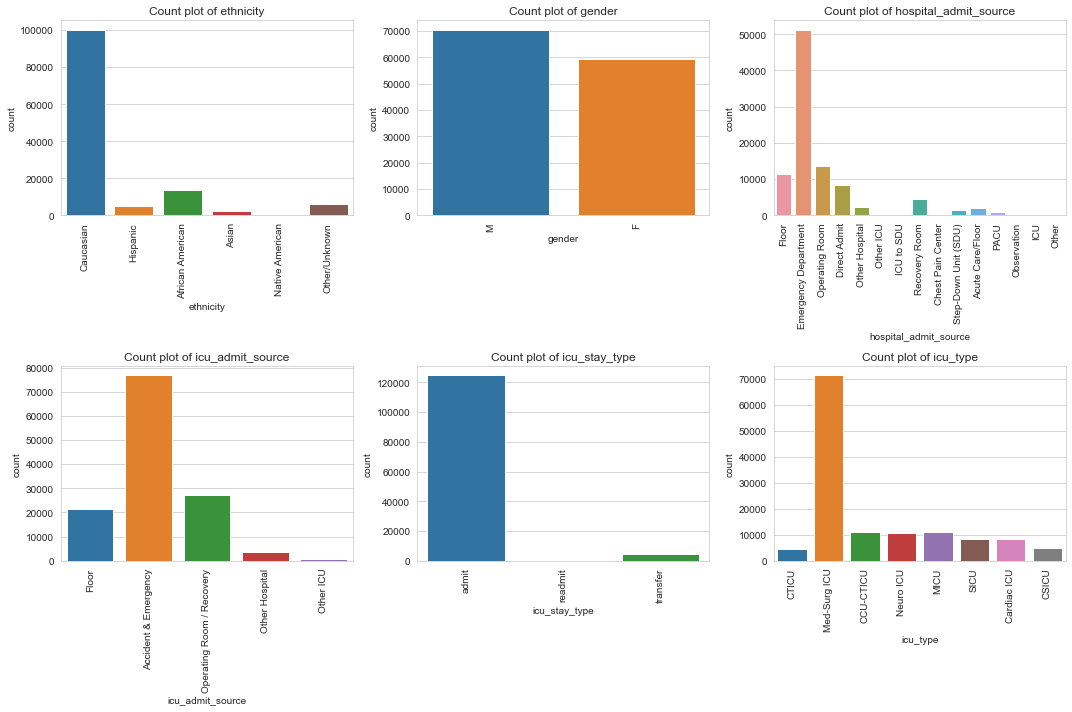

In [253]:
plt.figure(figsize=(15,10))
vars_to_look = diabetes[demographic_features].select_dtypes("O").columns
for i, var in enumerate(vars_to_look):
    plt.subplot(2,3,i+1)
    plt.xticks(rotation = 90)
    sns.countplot(diabetes[var])
    plt.title("Count plot of " + var)
plt.tight_layout()

In [254]:
diabetes.pivot_table(values="diabetes_mellitus",
                     index="gender",
                     columns="ethnicity",
                     aggfunc='mean',
                     fill_value=None,
#                     margins=True
                    ).style.highlight_max(color='lightgreen')

ethnicity,African American,Asian,Caucasian,Hispanic,Native American,Other/Unknown
gender,,,,,,
F,0.287239,0.228053,0.198517,0.237708,0.315556,0.262158
M,0.239698,0.260000,0.211470,0.253599,0.326882,0.249931


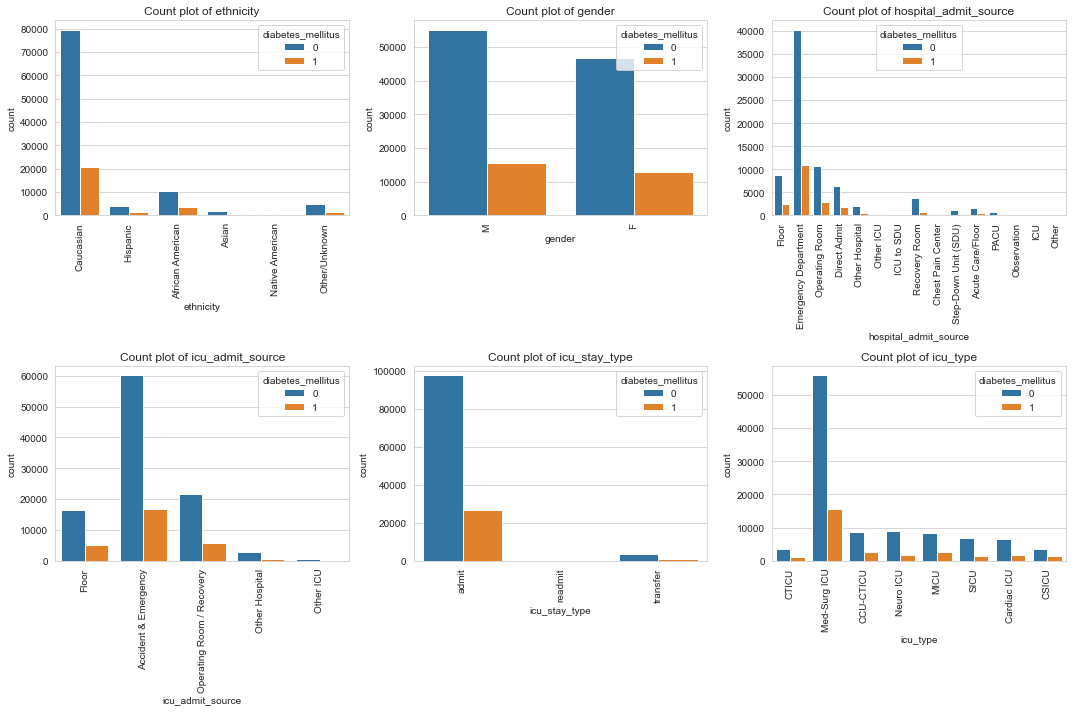

In [178]:
plt.figure(figsize=(15,10))
vars_to_look = diabetes[demographic_features].select_dtypes("O").columns
for i, var in enumerate(vars_to_look):
    plt.subplot(2,3,i+1)
    plt.xticks(rotation = 90)
    sns.countplot(x=var, data=diabetes,hue="diabetes_mellitus")
    plt.title("Count plot of " + var)
plt.tight_layout()

In [131]:
diabetes[demographic_features].select_dtypes("O")

,hospital_id,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type
0,118,Caucasian,M,Floor,Floor,admit,CTICU
1,81,Caucasian,F,Floor,Floor,admit,Med-Surg ICU
2,118,Caucasian,F,Emergency Department,Accident & Emergency,admit,Med-Surg ICU
3,118,Caucasian,F,Operating Room,Operating Room / Recovery,admit,CTICU
4,33,Caucasian,M,NaN,Accident & Emergency,admit,Med-Surg ICU
...,...,...,...,...,...,...,...
130152,7,Caucasian,M,Emergency Department,Accident & Emergency,admit,Cardiac ICU
130153,7,Caucasian,F,Direct Admit,Accident & Emergency,admit,MICU
130154,7,African American,M,Emergency Department,Accident & Emergency,admit,Cardiac ICU
130155,170,Caucasian,M,Emergency Department,Accident & Emergency,admit,Med-Surg ICU


In [150]:
diabetes[demographic_features].iloc[:,2:].describe()

,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,weight,diabetes_mellitus
count,125169.000000,125667.000000,130157.000000,128080.000000,130157.000000,130157.000000,130157.0,126694.000000,130157.000000
mean,61.995103,29.110260,0.189840,169.607219,662.428344,0.839933,0.0,83.791104,0.216285
std,16.822880,8.262776,0.392176,10.833085,304.259843,2.485337,0.0,24.963063,0.411712
min,0.000000,14.844926,0.000000,137.200000,82.000000,-0.250000,0.0,38.600000,0.000000
25%,52.000000,23.598006,0.000000,162.500000,427.000000,0.045833,0.0,66.500000,0.000000
50%,64.000000,27.564749,0.000000,170.100000,653.000000,0.155556,0.0,80.000000,0.000000
75%,75.000000,32.803127,0.000000,177.800000,969.000000,0.423611,0.0,96.800000,0.000000
max,89.000000,67.814990,1.000000,195.590000,1111.000000,175.627778,0.0,186.000000,1.000000


In [184]:
diabetes.groupby(["diabetes_mellitus"])[["pre_icu_los_days"]].describe()

pre_icu_los_days                                          \
                             count      mean       std       min       25%   
diabetes_mellitus                                                            
0                         102006.0  0.811025  2.417159 -0.250000  0.044444   
1                          28151.0  0.944681  2.715564 -0.211806  0.050000   

                                                   
                        50%       75%         max  
diabetes_mellitus                                  
0                  0.152778  0.412500  175.627778  
1                  0.168056  0.476042  159.090972

In [154]:
diabetes["readmission_status"].value_counts()

0    130157
Name: readmission_status, dtype: int64

In [181]:
diabetes.groupby(["diabetes_mellitus"])[["age","bmi","height","weight"]].mean()

,age,bmi,height,weight
diabetes_mellitus,,,,
0,61.272026,28.375530,169.631770,81.750636
1,64.564257,31.765574,169.518772,91.177235


In [183]:
diabetes.groupby(["ethnicity","diabetes_mellitus"])[["age","bmi","height","weight"]].mean()

age        bmi      height  \
ethnicity        diabetes_mellitus                                     
African American 0                  54.578858  29.405794  170.853703   
                 1                  60.436238  32.127416  170.018133   
Asian            0                  59.972414  25.238583  162.486889   
                 1                  66.744681  26.060955  162.301600   
Caucasian        0                  62.716619  28.309793  169.940517   
                 1                  65.602809  32.060064  170.137403   
Hispanic         0                  58.634173  28.266986  165.521073   
                 1                  63.257048  29.685886  165.534566   
Native American  0                  49.748777  29.979039  168.415922   
                 1                  56.346939  33.202034  167.984296   
Other/Unknown    0                  56.493515  28.150031  167.413768   
                 1                  62.520408  30.282623  166.022567   

                                       weight  
ethnicity        diabetes_mellitus             
African American 0                  85.611139  
                 1                  92.437716  
Asian            0                  66.762939  
                 1                  68.713988  
Caucasian        0                  81.869501  
                 1                  92.651057  
Hispanic         0                  77.532792  
                 1                  81.534276  
Native American  0                  85.248013  
                 1                  93.366471  
Other/Unknown    0                  78.983490  
                 1                  83.424892

Observations :
As expected, looks like  heavier people are prone to diabetes

* ethnicity looks important
* icu_id is irrelevant
* readmission_status is totally NULL

## APACHE comorbidity

In [238]:
data_info[data_info["Category"]=="APACHE comorbidity"].sort_values(["Data Type","Variable Name"])

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
173,APACHE comorbidity,aids,None,binary,Whether the patient has a definitive diagnosis...,1
174,APACHE comorbidity,cirrhosis,None,binary,Whether the patient has a history of heavy alc...,1
175,APACHE comorbidity,hepatic_failure,None,binary,Whether the patient has cirrhosis and addition...,1
176,APACHE comorbidity,immunosuppression,None,binary,Whether the patient has their immune system su...,1
177,APACHE comorbidity,leukemia,None,binary,Whether the patient has been diagnosed with ac...,1
178,APACHE comorbidity,lymphoma,None,binary,Whether the patient has been diagnosed with no...,1
179,APACHE comorbidity,solid_tumor_with_metastasis,None,binary,Whether the patient has been diagnosed with an...,1


In [255]:
apache_comorbidity_features = ["encounter_id","hospital_id"]
apache_comorbidity_features = apache_comorbidity_features + data_info[data_info["Category"]=="APACHE comorbidity"].sort_values(["Data Type","Variable Name"])["Variable Name"].unique().tolist()
apache_comorbidity_features.append("diabetes_mellitus")

In [256]:
diabetes[apache_comorbidity_features].isnull().sum()

encounter_id                   0
hospital_id                    0
aids                           0
cirrhosis                      0
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
diabetes_mellitus              0
dtype: int64

In [257]:
diabetes[apache_comorbidity_features].iloc[:,2:-1].apply(lambda x:x.value_counts())

,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,130023,128064,128387,126816,129206,129612,127443
1,134,2093,1770,3341,951,545,2714


In [258]:
def chi2_contingency_test(df,target,variable):
    print(pd.crosstab(df[target],df[variable]))
    g, p, dof, expctd = chi2_contingency(pd.crosstab(df[target],df[variable]))
    print(f"p-value of Chi-square test for {target} vs. {variable} =", p)

In [259]:
chi2_contingency_test(diabetes,"diabetes_mellitus","aids")

aids                    0    1
diabetes_mellitus             
0                  101883  123
1                   28140   11
p-value of Chi-square test for diabetes_mellitus vs. aids = 0.00024248126608415052


In [260]:
chi2_contingency_test(diabetes,"diabetes_mellitus","cirrhosis")

cirrhosis               0     1
diabetes_mellitus              
0                  100468  1538
1                   27596   555
p-value of Chi-square test for diabetes_mellitus vs. cirrhosis = 5.050784627645201e-08


In [261]:
chi2_contingency_test(diabetes,"diabetes_mellitus","hepatic_failure")

hepatic_failure         0     1
diabetes_mellitus              
0                  100678  1328
1                   27709   442
p-value of Chi-square test for diabetes_mellitus vs. hepatic_failure = 0.0006478012566495153


In [262]:
chi2_contingency_test(diabetes,"diabetes_mellitus","immunosuppression")

immunosuppression      0     1
diabetes_mellitus             
0                  99362  2644
1                  27454   697
p-value of Chi-square test for diabetes_mellitus vs. immunosuppression = 0.2851241513436893


In [263]:
chi2_contingency_test(diabetes,"diabetes_mellitus","leukemia")

leukemia                0    1
diabetes_mellitus             
0                  101277  729
1                   27929  222
p-value of Chi-square test for diabetes_mellitus vs. leukemia = 0.21128422465445623


In [264]:
chi2_contingency_test(diabetes,"diabetes_mellitus","lymphoma")

lymphoma                0    1
diabetes_mellitus             
0                  101578  428
1                   28034  117
p-value of Chi-square test for diabetes_mellitus vs. lymphoma = 0.968787775041885


In [265]:
chi2_contingency_test(diabetes,"diabetes_mellitus","solid_tumor_with_metastasis")

solid_tumor_with_metastasis      0     1
diabetes_mellitus                       
0                            99778  2228
1                            27665   486
p-value of Chi-square test for diabetes_mellitus vs. solid_tumor_with_metastasis = 2.188993359520709e-06


Observations : 

* cirrhosis and hepatic_failure both features sometimes related to drinking alcohol . Commonly Type 2 diabetes is associated with a large number of liver disorders. 
* Patients with type 2 diabetes have a 20 per cent increased risk of developing blood cancers [URL](https://www.sciencedaily.com/releases/2012/06/120605121658.htm#:~:text=developing%20blood%20cancers.-,Patients%20with%20type%202%20diabetes%20have%20a%2020%20percent%20increased,researchers%20at%20The%20Miriam%20Hospital.) but the dataset provided does not present this behavior , might look for confounding variables

## APACHE covariate

In [266]:
data_info[data_info["Category"]=="APACHE covariate"].sort_values(["Data Type","Variable Name"])

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
20,APACHE covariate,apache_post_operative,None,binary,The APACHE operative status; 1 for post-operat...,1
21,APACHE covariate,arf_apache,None,binary,Whether the patient had acute renal failure du...,0
28,APACHE covariate,gcs_unable_apache,None,binary,Whether the Glasgow Coma Scale was unable to b...,1
33,APACHE covariate,intubated_apache,None,binary,Whether the patient was intubated at the time ...,0
43,APACHE covariate,ventilated_apache,None,binary,Whether the patient was invasively ventilated ...,1
26,APACHE covariate,gcs_eyes_apache,None,integer,The eye opening component of the Glasgow Coma ...,4
27,APACHE covariate,gcs_motor_apache,None,integer,The motor component of the Glasgow Coma Scale ...,6
29,APACHE covariate,gcs_verbal_apache,None,integer,The verbal component of the Glasgow Coma Scale...,5
17,APACHE covariate,albumin_apache,g/L,numeric,The albumin concentration measured during the ...,30
22,APACHE covariate,bilirubin_apache,micromol/L,numeric,The bilirubin concentration measured during th...,20


In [246]:
apache_covariate_features = ["encounter_id","hospital_id"]
apache_covariate_features = apache_covariate_features + data_info[data_info["Category"]=="APACHE covariate"].sort_values(["Data Type","Variable Name"])["Variable Name"].unique().tolist()
apache_covariate_features.append("diabetes_mellitus")

In [282]:
diabetes[apache_covariate_features].iloc[:,2:].isnull().mean().sort_values(ascending=False)

paco2_apache             0.766152
fio2_apache              0.766152
ph_apache                0.766152
pao2_apache              0.766152
paco2_for_ph_apache      0.766152
bilirubin_apache         0.634311
albumin_apache           0.600529
urineoutput_apache       0.485314
wbc_apache               0.226457
hematocrit_apache        0.205582
bun_apache               0.195233
creatinine_apache        0.191169
sodium_apache            0.188380
glucose_apache           0.112910
temp_apache              0.050793
gcs_verbal_apache        0.016826
gcs_motor_apache         0.016826
gcs_eyes_apache          0.016826
apache_2_diagnosis       0.012946
apache_3j_diagnosis      0.006646
resprate_apache          0.006208
gcs_unable_apache        0.005447
map_apache               0.003227
heart_rate_apache        0.002374
arf_apache               0.000000
diabetes_mellitus        0.000000
intubated_apache         0.000000
ventilated_apache        0.000000
apache_post_operative    0.000000
dtype: float64

In [273]:
diabetes[apache_covariate_features].iloc[:,2:7].apply(lambda x:x.value_counts())

,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache
0.0,103200,126513,127967,109771,87149
1.0,26957,3644,1481,20386,43008


In [274]:
chi2_contingency_test(diabetes,"diabetes_mellitus","apache_post_operative")

apache_post_operative      0      1
diabetes_mellitus                  
0                      80624  21382
1                      22576   5575
p-value of Chi-square test for diabetes_mellitus vs. apache_post_operative = 2.2883967112267962e-05


In [276]:
chi2_contingency_test(diabetes,"diabetes_mellitus","arf_apache")

arf_apache              0     1
diabetes_mellitus              
0                  100109  1897
1                   26404  1747
p-value of Chi-square test for diabetes_mellitus vs. arf_apache = 0.0


In [277]:
chi2_contingency_test(diabetes,"diabetes_mellitus","gcs_unable_apache")

gcs_unable_apache     0.0   1.0
diabetes_mellitus              
0                  100125  1232
1                   27842   249
p-value of Chi-square test for diabetes_mellitus vs. gcs_unable_apache = 5.1705418679112256e-06


In [275]:
chi2_contingency_test(diabetes,"diabetes_mellitus","ventilated_apache")

ventilated_apache      0      1
diabetes_mellitus              
0                  68600  33406
1                  18549   9602
p-value of Chi-square test for diabetes_mellitus vs. ventilated_apache = 1.810732193575899e-05


Observations :

This feautures are mostly missing, but commonly this feautes are useful 
 
* **Feature**              **% Missing**
* paco2_apache             0.766152
* fio2_apache              0.766152
* ph_apache                0.766152
* pao2_apache              0.766152
* paco2_for_ph_apache      0.766152
* bilirubin_apache         0.634311
* albumin_apache           0.600529
* urineoutput_apache       0.485314

## vitals

## labs

## labs blood gas